In [1]:
suppressMessages(library(scran))
library(BiocParallel)
library(parallel)
library(muscat)
suppressMessages(library(limma))
suppressMessages(library(EnhancedVolcano))
library(patchwork)
suppressMessages(library(Seurat))
suppressPackageStartupMessages(library(tidyverse))

In [2]:
checksig=function(res_table, pcutoff=0.01, FCcutoff=1){
    if (res_table$cluster_id[1]!='Plasma cells'){
   res_table=res_table %>% filter(gene!='JCHAIN')}
sigcount=res_table %>% filter(p_adj.loc	<pcutoff, abs(logFC)>FCcutoff) %>% nrow()
    return(sigcount>0)
    }

In [3]:
getvolcone=function(res_table, pcutoff=0.01, FCcutoff=1, connector=F, exhaust=F){
    if (res_table$cluster_id[1]!='Plasma cells'){ #Hide Jchain is the comparison is not for plasma cells, due to bleeding over of Jchain
   res_table=res_table %>% filter(gene!='JCHAIN')}
    if (exhaust==T){
        selectlab=c('PDCD1', 'CTLA4', 'LAG3', 'HAVCR2', 'CD244', 'CD160', 'TIGIT') 
    }else{selectlab=NULL }
p=EnhancedVolcano(res_table,
                  lab = res_table$gene,
                  x = 'logFC',
                  y = 'p_adj.loc',
                  title=res_table$cluster_id[1],
               subtitle =NULL,
                pCutoff = pcutoff,
                FCcutoff = FCcutoff,
                 legendPosition = 'none',
                 ylim = c(0, max(max(-log10(res_table$p_adj.loc), na.rm = TRUE) + 1, -log10(0.05)+1)),
                 caption=NULL,
                 pointSize = 0.5, 
                   drawConnectors = connector,                  
                 selectLab=selectlab #Visualize exhaustion marker specifically
                 )    
    }

In [2]:
seuratobj_full=readRDS('/mnt/MXMERZ002A/LargeData/seuratobj_1.rds')

In [5]:
#Preprocess seuratobj_full
seuratobj_full=DietSeurat(
  seuratobj_full,
  counts = TRUE,
  data = T,
  scale.data = FALSE,
  features = NULL,
  assays = 'RNA',
  dimreducs = F,
  graphs = F
)
#seuratobj_full <- NormalizeData(seuratobj_full, normalization.method = "CLR", margin = 2, assay = "ADT")
seuratobj_full@meta.data=seuratobj_full@meta.data %>% 
mutate(timepoint=ifelse(days.since.apharesis<2, 'apharesis','post_infusion')) %>%
unite(orig.ident.WNN_l2, orig.ident, WNN_l2, remove=F) 

seuratobj_full$idecabtagene_pos=GetAssayData(seuratobj_full, slot='counts', assay = 'RNA')['idecabtagene',]>0
seuratobj_full$ciltacabtagene_pos=GetAssayData(seuratobj_full, slot='counts', assay = 'RNA')['ciltacabtagene',]>0

genenames=rownames(seuratobj_full)

IGHVgenes=genenames[grep('^IGHV', genenames)]
IGLVgenes=genenames[grep('^IGK|^IGL', genenames)]
TRgenes=genenames[grep('^TR(B|A)V', genenames)]
CARgenes=c('ciltacabtagene', 'idecabtagene')
sexgenes=c('XIST', 'RPS4Y1', 'RPS4Y2')

informative_genes=setdiff(genenames, Reduce(union, list(IGHVgenes, IGLVgenes, TRgenes, sexgenes, CARgenes)))
seuratobj_full=seuratobj_full[informative_genes, ] 

In [6]:
#Classify PR as nonCR
seuratobj_full@meta.data=seuratobj_full@meta.data %>% mutate(response=ifelse(remission.after.CAR=='CR', 'CR', 'nonCR'))

In [8]:
#subset for non CART and main cell types
seuratobj=seuratobj_full[informative_genes,                       
                        seuratobj_full$WNN_agg!='Others'&
                        seuratobj_full$idecabtagene_pos==F&
                         seuratobj_full$ciltacabtagene_pos==F
                       ]

In [8]:
#Exhaustion markers
#c('PDCD1', 'CTLA4', 'LAG3', 'HAVCR2', 'CD244', 'CD160', 'TIGIT')

# Comparison of RNA expressions between nonCR and CR patients
The following comparisons were made:
- nonCR vs CR in premanufacture PBMC samples for all cell types excluding CAR-T cells
- nonCR vs CR in post infusion PBMC samples for all cell types excluding CAR-T cells
- nonCR vs CR in post infusion BMMC samples for all cell types excluding CAR-T cells
- post-infusion vs apharesis in nonCR PBMC samples for all cell types excluding CAR-T cells
- post-infusion vs apharesis in CR PBMC samples for all cell types excluding CAR-T cells

## Pre-manufacture PBMCs 
Here we compared the pre-manufacture PBMC nonCR and CR samples. Positive log fold change means upregulated in nonCR samples. 

In [22]:
seuratobj_sub=seuratobj[,
                        seuratobj$source=='PB'&
                        seuratobj$timepoint=='apharesis'
                       ]

In [23]:
pbmc.sce <- as.SingleCellExperiment(seuratobj_sub)
pbmc.sce=prepSCE(
  pbmc.sce,
  kid = "WNN_l2",
  sid = "orig.ident",
  gid = "response",
  drop = T
)

In [24]:
pb <- aggregateData(pbmc.sce,
                    assay = "counts", fun = "sum",
                    by = c("cluster_id", "sample_id"),
                    BPPARAM = MulticoreParam(workers=8)
                   )

In [25]:
design_mat=model.matrix(~0+group_id,colData(pb))
contrast=makeContrasts(group_idnonCR-group_idCR,levels=design_mat)

In [26]:
res_deseq2_pre=pbDS(
  pb,
  method = "DESeq2",
  design = design_mat,
  contrast = contrast,
  min_cells = 10,  
  treat = FALSE,
  verbose = TRUE,
  BPPARAM = MulticoreParam(workers=8)
)

In [27]:
res_pre_tables=res_deseq2_pre$table[[1]]

In [28]:
volcones_deseq2=lapply(res_pre_tables[sapply(res_pre_tables,checksig)], getvolcone) #Deseq2 has most results

Unless otherwise mentioned, p value and logFC thresholds are 0.01 and 1 respectively. Cell cluster with no DEGs are omitted. Results saved in premanufacture_pbmc.csv.

In [15]:
bind_rows(res_pre_tables) %>% filter(p_adj.loc<0.05) %>% dplyr::select(gene, cluster_id, logFC, p.val=p_val, p.val.adjusted=p_adj.loc) %>% 
write_csv('premanufacture_pbmc.csv')

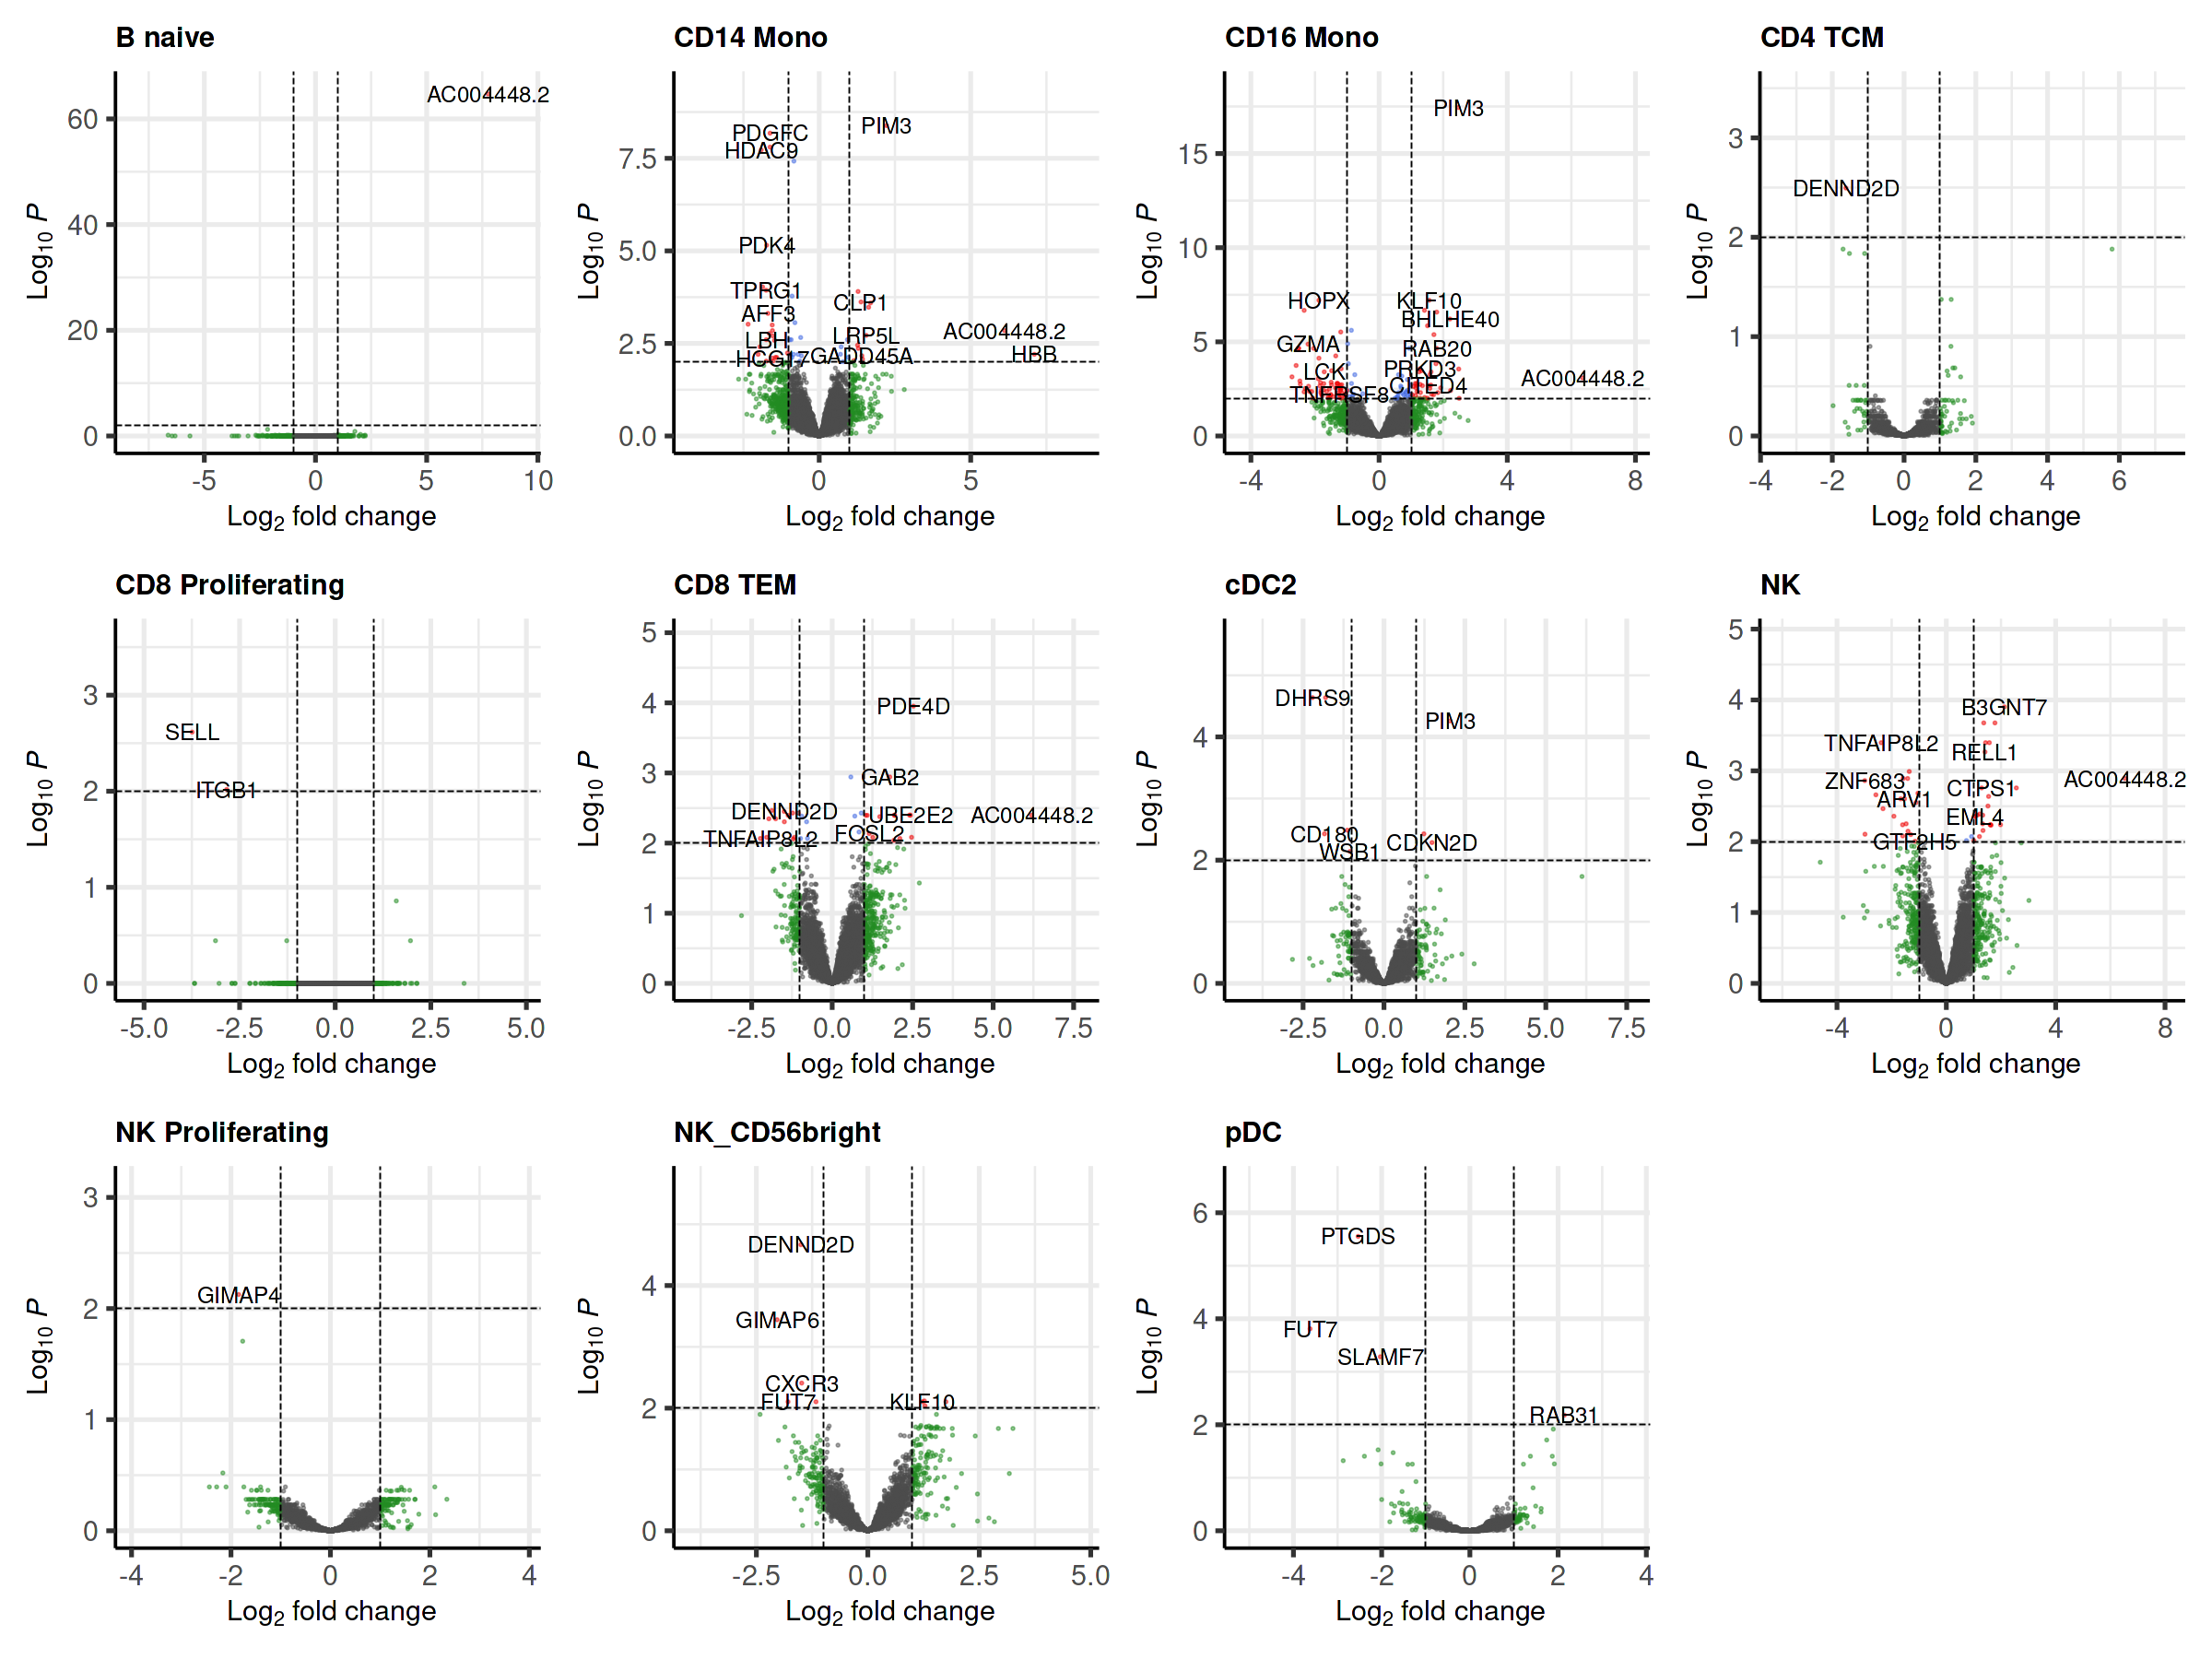

In [29]:
# Figure 4D
options(repr.plot.width=20, repr.plot.height=15)
wrap_plots(volcones_deseq2)

In [39]:
suppressPackageStartupMessages(library(clusterProfiler))
suppressPackageStartupMessages(library(org.Hs.eg.db))
library(parallel)

In [37]:
plotcnet=function(res_table, direction, pcutoff=0.01, wraplength=30){

# res_table=res_deseq2$table[[1]][[3]]
# direction='up'
# pcutoff=0.01
    if (direction=='up'){
genelist=res_table %>% filter(p_adj.loc<pcutoff, logFC>1) %>% dplyr::select(gene) %>% unlist
        title='upregulated'
        } else {
        genelist=res_table %>% filter(p_adj.loc<pcutoff, logFC< -1) %>% dplyr::select(gene) %>% unlist
        title='downregulated'
    }

    if (length(genelist)<4){
        return(list(NULL, NULL))
    }

geneset <- enrichGO(gene   = genelist,
                    OrgDb         = org.Hs.eg.db,
                    keyType       = 'ALIAS',
                    ont           = "BP",
                    pAdjustMethod = "BH",
                    universe=res_table$gene)

if (nrow(geneset)==0){
    return(list(geneset, NULL))
}
    res_table=res_table %>% column_to_rownames('gene')
    genefc=res_table[geneset@gene,'logFC']
    names(genefc)=geneset@gene
    
    cluster_id=res_table$cluster_id[1]
    
#bp <- simplify(geneset, cutoff=0.7, by="p.adjust", select_fun=min)
#p2 <- cnetplot(geneset, categorySize="pvalue")+ggtitle(cluster_id)
    p2=heatplot(geneset, foldChange =genefc, showCategory=10,label_format =wraplength)+ggtitle(cluster_id)
    return(list(geneset, p2))
}

In [77]:
upregulated_prepbmc=lapply(res_deseq2_pre$table[[1]], plotcnet, pcutoff=0.01, direction='up', wraplength=100) #Can't run in parallel because of org.Hs.eg.db

In [78]:
upregulated_prepbmc_plot=map(upregulated_prepbmc, 2)

The following plots show enriched biological processes for upregulated and downregulated genes
Upregulated means more highly expressed in nonCR vs CR. Only the top ten pathways in terms of p value are shown.

In [79]:
upregulated_prepbmc_plot_filtered=upregulated_prepbmc_plot[!sapply(upregulated_prepbmc_plot, is.null)]

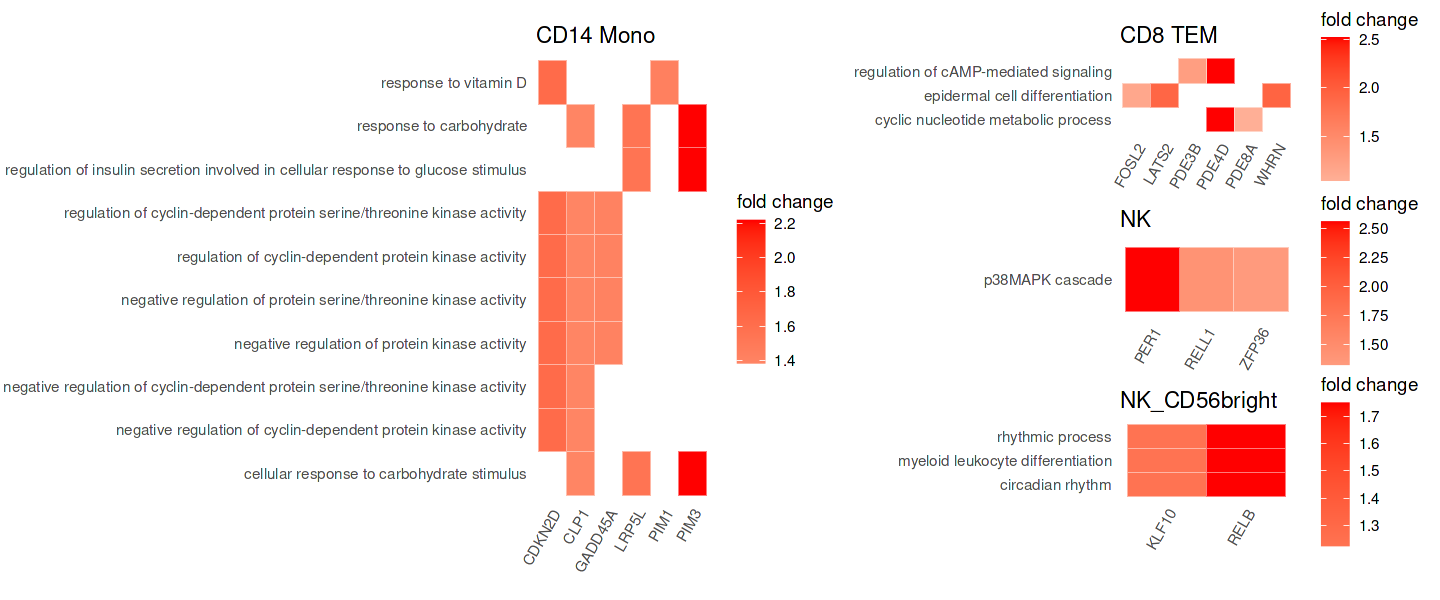

In [83]:
options(repr.plot.width=12, repr.plot.height=5)
upregulated_prepbmc_plot_filtered[[1]]=upregulated_prepbmc_plot_filtered[[1]]+theme(plot.margin = margin(10, 10, 10, 10))
upregulated_prepbmc_plot_filtered[[1]]|upregulated_prepbmc_plot_filtered[[2]]/upregulated_prepbmc_plot_filtered[[3]]/upregulated_prepbmc_plot_filtered[[4]]

In [103]:
downregulated_prepbmc=lapply(res_deseq2_pre$table[[1]], plotcnet, pcutoff=0.01, direction='down', wraplength=100)

In [104]:
downregulated_prepbmc_plot=map(downregulated_prepbmc, 2)

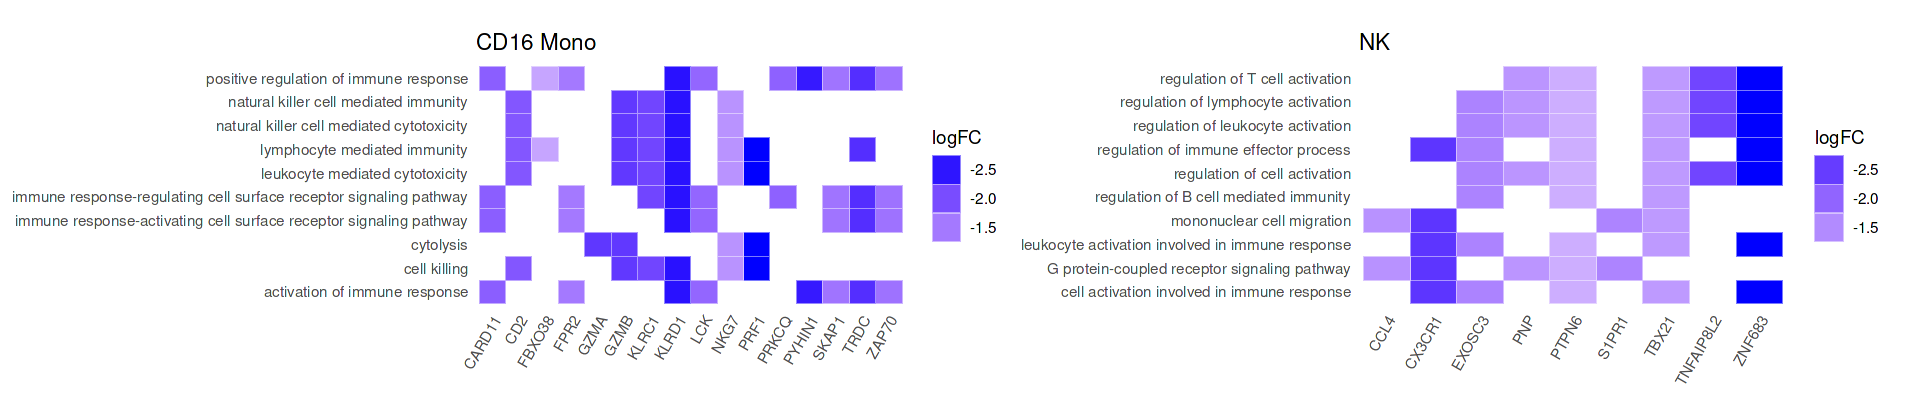

In [118]:
#Figure 4D
options(repr.plot.width=16, repr.plot.height=3.5)
wrap_plots(downregulated_prepbmc_plot[!sapply(downregulated_prepbmc_plot, is.null)]) &  guides(fill=guide_legend(title="logFC")) & 
  theme(plot.margin = margin(10, 10, 10, 10))

## Post-infusion BMMCs 
Here we compared the post-infusion BMMC nonCR to CR samples. As before, postive logFC means upregulated in nonCR samples. 
Results saved in postinfusion_bmmc.csv. 

In [31]:
seuratobj_sub=seuratobj[,
                        seuratobj$source=='BM']

In [32]:
seuratobj_sub@meta.data=seuratobj_sub@meta.data %>% mutate(isplasmacells=ifelse(WNN_l2=='Plasma cells', T, F))

In [33]:
#Downsample plasma cells
seuratobj_sub_split=SplitObject(seuratobj_sub, split.by='isplasmacells')
Idents(seuratobj_sub_split[[2]])='orig.ident'
seuratobj_sub_split[[2]]=subset(seuratobj_sub_split[[2]], downsample=50)
seuratobj_sub=merge(seuratobj_sub_split[[1]], seuratobj_sub_split[[2]])

In [34]:
pbmc.sce <- as.SingleCellExperiment(seuratobj_sub)

In [35]:
pbmc.sce=prepSCE(
  pbmc.sce,
  kid = "WNN_l2",
  sid = "orig.ident",
  gid = "response",
  drop = F
)
pb <- aggregateData(pbmc.sce,
                    assay = "counts", fun = "sum",
                    by = c("cluster_id", "sample_id"),
                    BPPARAM = MulticoreParam(workers=8)
                   )

In [36]:
design_mat=model.matrix(~0+group_id,colData(pb))

In [37]:
contrast=makeContrasts(group_idnonCR-group_idCR, levels=design_mat)

In [38]:
res_bm=pbDS(
    pb,
    method = "DESeq2",
    design = design_mat,
    contrast = contrast,
    min_cells = 10,  
    treat = FALSE,
    verbose = TRUE,
    BPPARAM = MulticoreParam(workers=8)
)

In [39]:
res_tables=res_bm$table[[1]]

In [49]:
volcones_bm=lapply(res_tables[sapply(res_tables,checksig)], getvolcone, connector=T) 

In [50]:
bind_rows(res_tables) %>% filter(p_adj.loc<0.05) %>% dplyr::select(gene, cluster_id, logFC, p.val=p_val, p.val.adjusted=p_adj.loc) %>% 
write_csv('postinfusion_bmmc.csv')

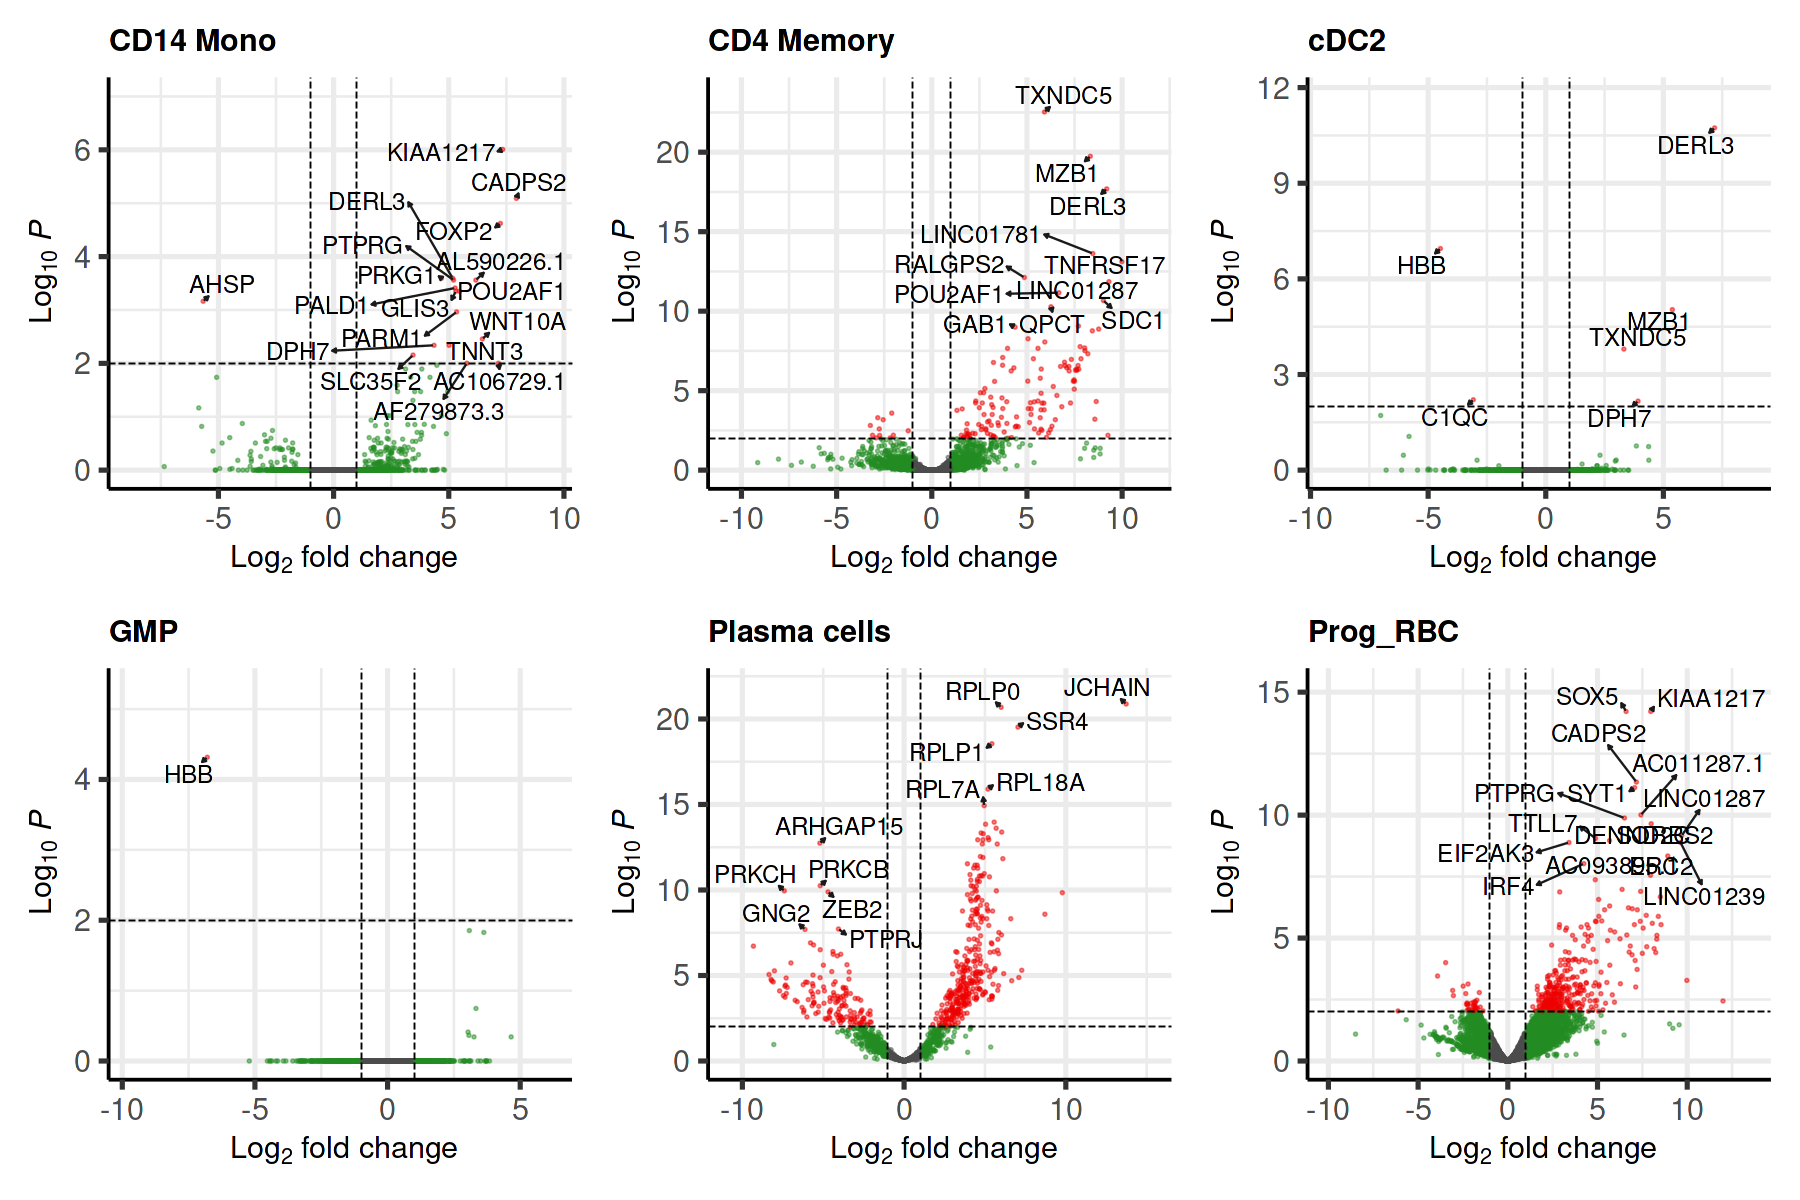

In [52]:
# Supp fig 1D
options(warn = -1)
options(repr.plot.width=15, repr.plot.height=10)
suppressWarnings(wrap_plots(volcones_bm))
options(warn = 0)

In [53]:
upregulated_bm=lapply(res_tables, plotcnet, pcutoff=0.01, direction='up') #Can't run in parallel because of org.Hs.eg.db

In [54]:
upregulated_bm_plot=map(upregulated_bm, 2)

In [58]:
wrapplot=wrap_plots(upregulated_bm_plot[!sapply(upregulated_bm_plot, is.null)], ncol = 1) &  guides(fill=guide_legend(title="logFC")) & 
  theme(plot.margin = margin(10, 10, 10, 10))

In [59]:
wrapplot[[1]]=wrapplot[[1]]+  theme(axis.text.x = element_text(size=7)) 

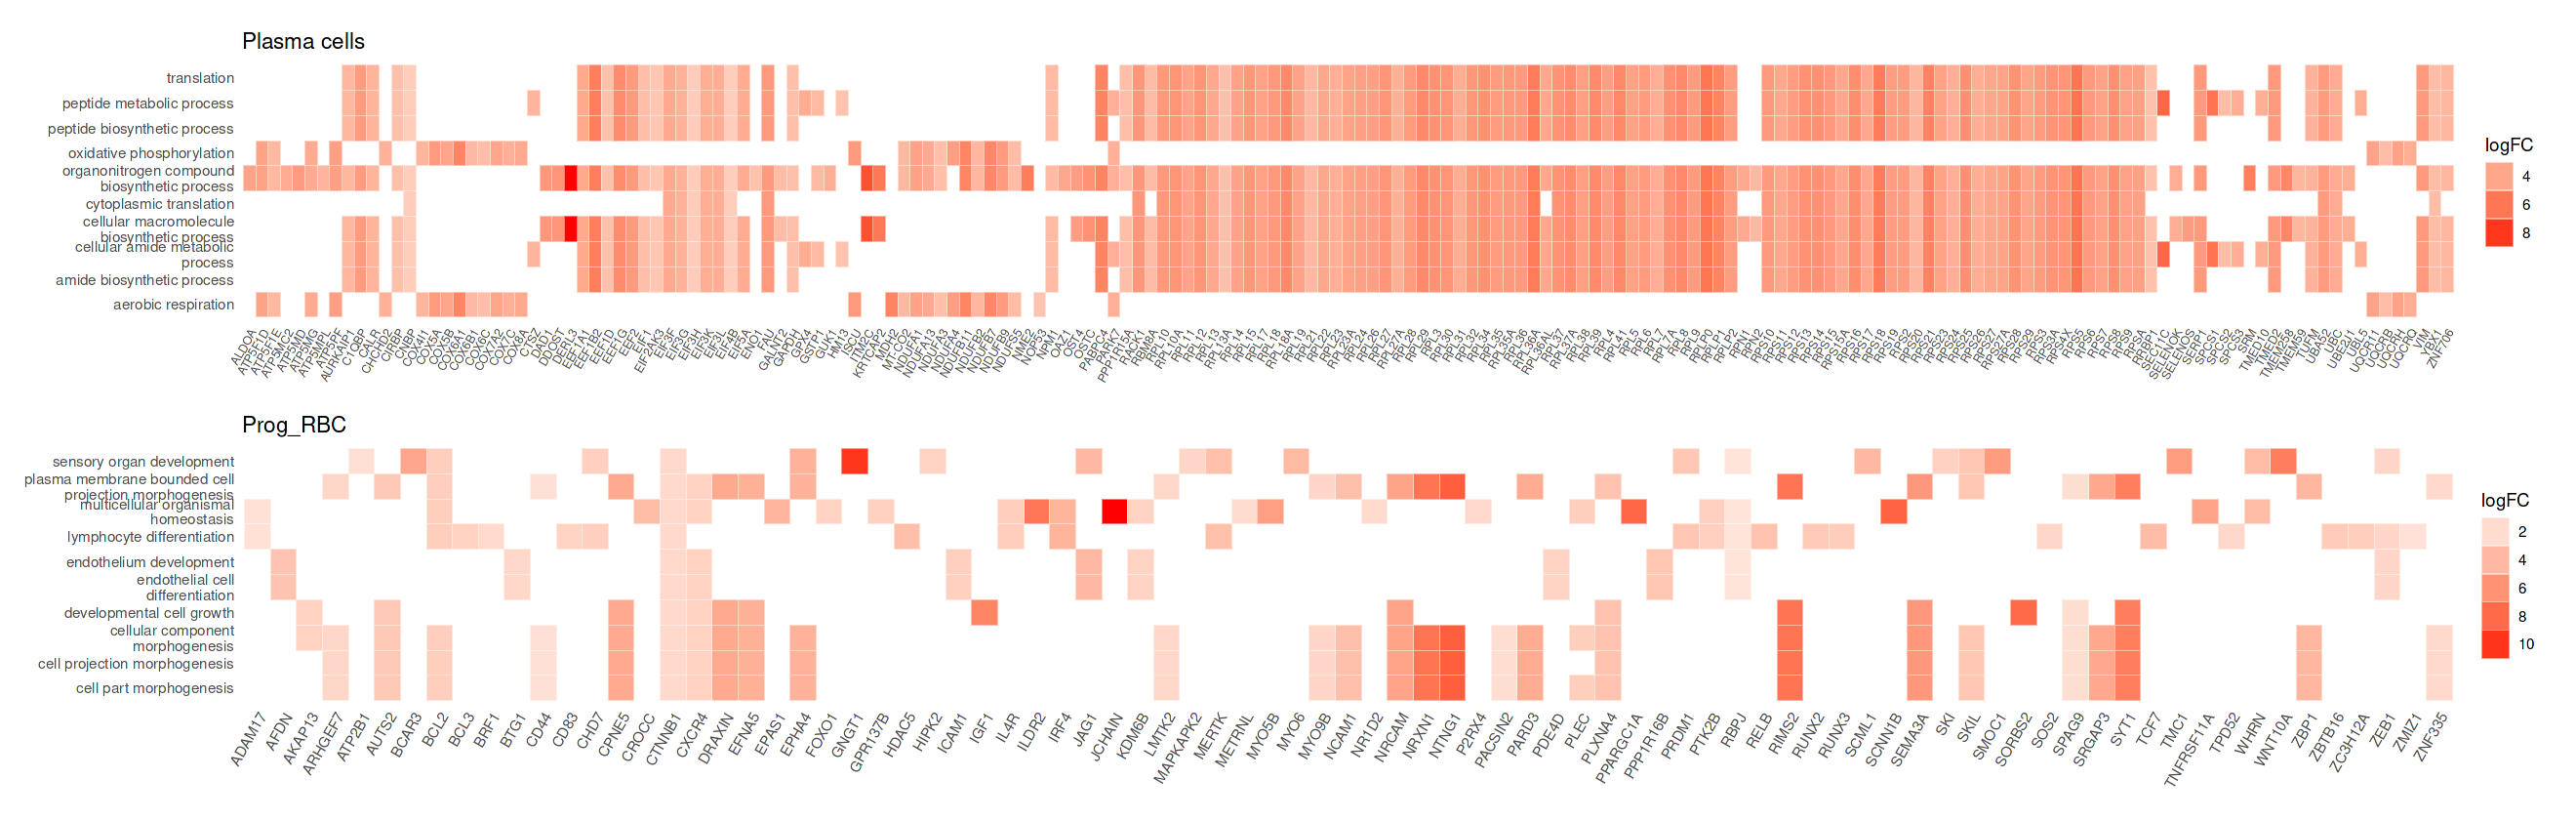

In [60]:
options(repr.plot.width=22, repr.plot.height=7)
wrapplot

In [61]:
downregulated_bm=lapply(res_tables, plotcnet, pcutoff=0.01, direction='down', wraplength=100) #Can't run in parallel because of org.Hs.eg.db

In [62]:
downregulated_bm_plot=map(downregulated_bm, 2)

In [63]:
plotlist=downregulated_bm_plot[!sapply(downregulated_bm_plot, is.null)]

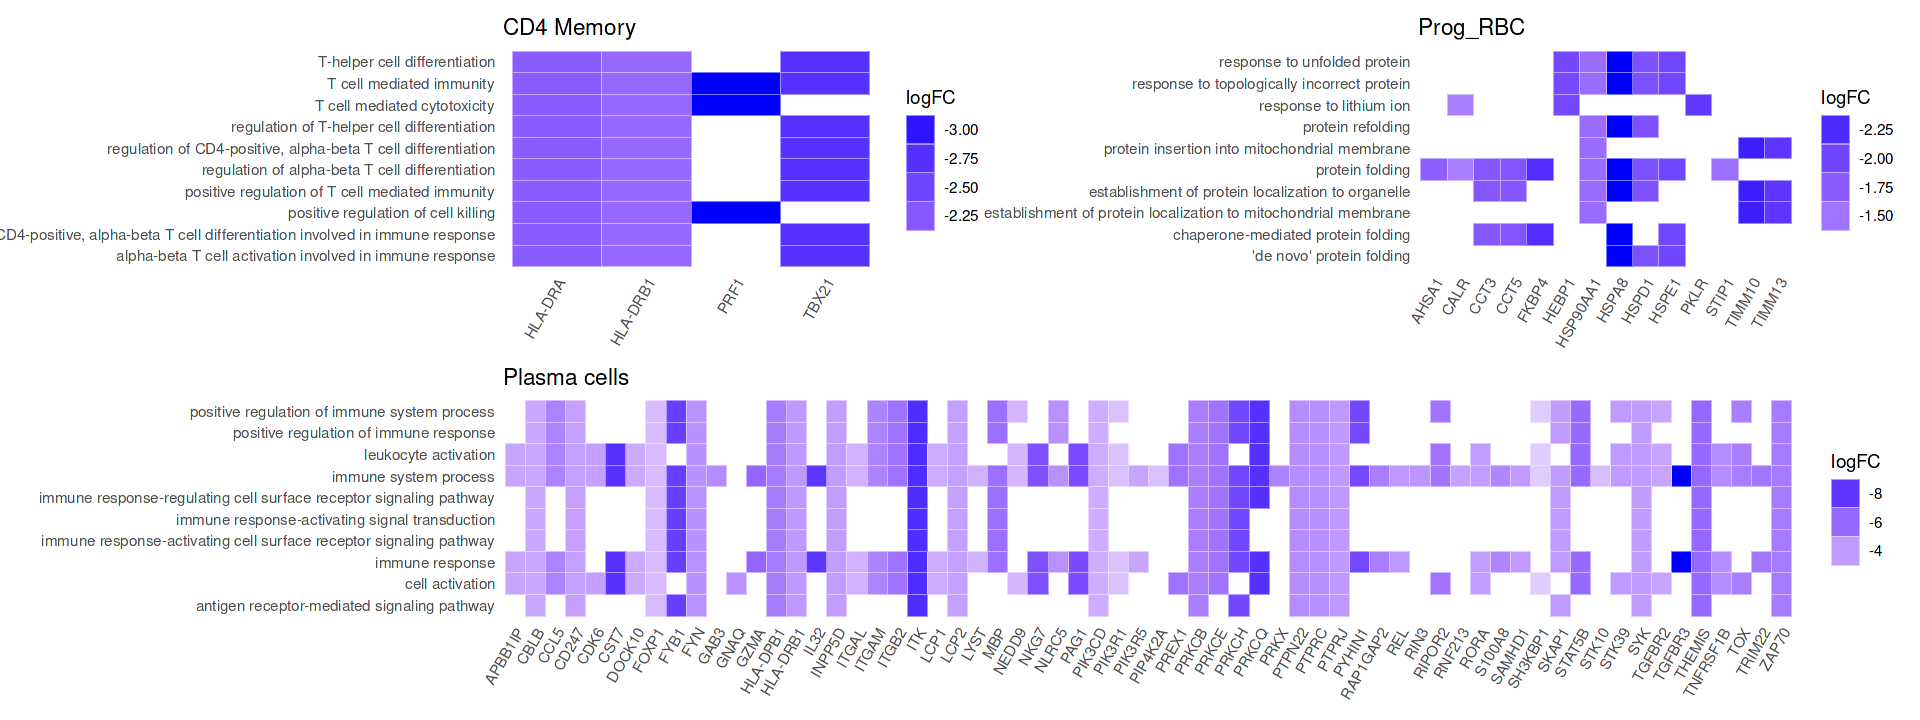

In [64]:
options(repr.plot.width=16, repr.plot.height=6)
(plotlist[[1]]|plotlist[[3]])/plotlist[[2]] &  guides(fill=guide_legend(title="logFC"))

## Post infusion vs Apharesis in CR
Here we compared post infusion to apharesis for CR samples only. Results saved in postinfusion_vs_apharesis_CR.csv. Positive logFC means upregulated in post infusion samples.

In [11]:
# Compare nonCR and CR separately
seuratobj_sub=seuratobj[,
                        seuratobj$source=='PB'&
                        seuratobj$response=='CR'&
                        seuratobj$patient!=7
                       ]

In [12]:
pbmc.sce <- as.SingleCellExperiment(seuratobj_sub)
pbmc.sce=prepSCE(
  pbmc.sce,
  kid = "WNN_l2",
  sid = "orig.ident",
  gid = "timepoint",
  drop = F
)

In [13]:
pb <- aggregateData(pbmc.sce,
                    assay = "counts", fun = "sum",
                    by = c("cluster_id", "sample_id"),
                    BPPARAM = MulticoreParam(workers=16)
                   )

In [14]:
design_mat=model.matrix(~0+group_id+patient,colData(pb))

In [15]:
contrast=makeContrasts(group_idpost_infusion-group_idapharesis, levels=design_mat)

In [16]:
res_CR=pbDS(
    pb,
    method = "DESeq2",
    design = design_mat,
    contrast = contrast,
    min_cells = 10,  
    treat = FALSE,
    verbose = TRUE,
    BPPARAM = MulticoreParam(workers=16)
)

In [17]:
res_tables_CR=res_CR$table[[1]]

In [18]:
bind_rows(res_tables_CR) %>% filter(p_adj.loc<0.05) %>% dplyr::select(gene, cluster_id, logFC, p.val=p_val, p.val.adjusted=p_adj.loc) %>% 
write_csv('postinfusion_vs_apharesis_CR.csv')

In [19]:
volcones_deseq2_separate_CR=lapply(res_tables_CR[sapply(res_tables_CR,checksig, pcutoff=0.01)], getvolcone, pcutoff=0.01, connector=F) 

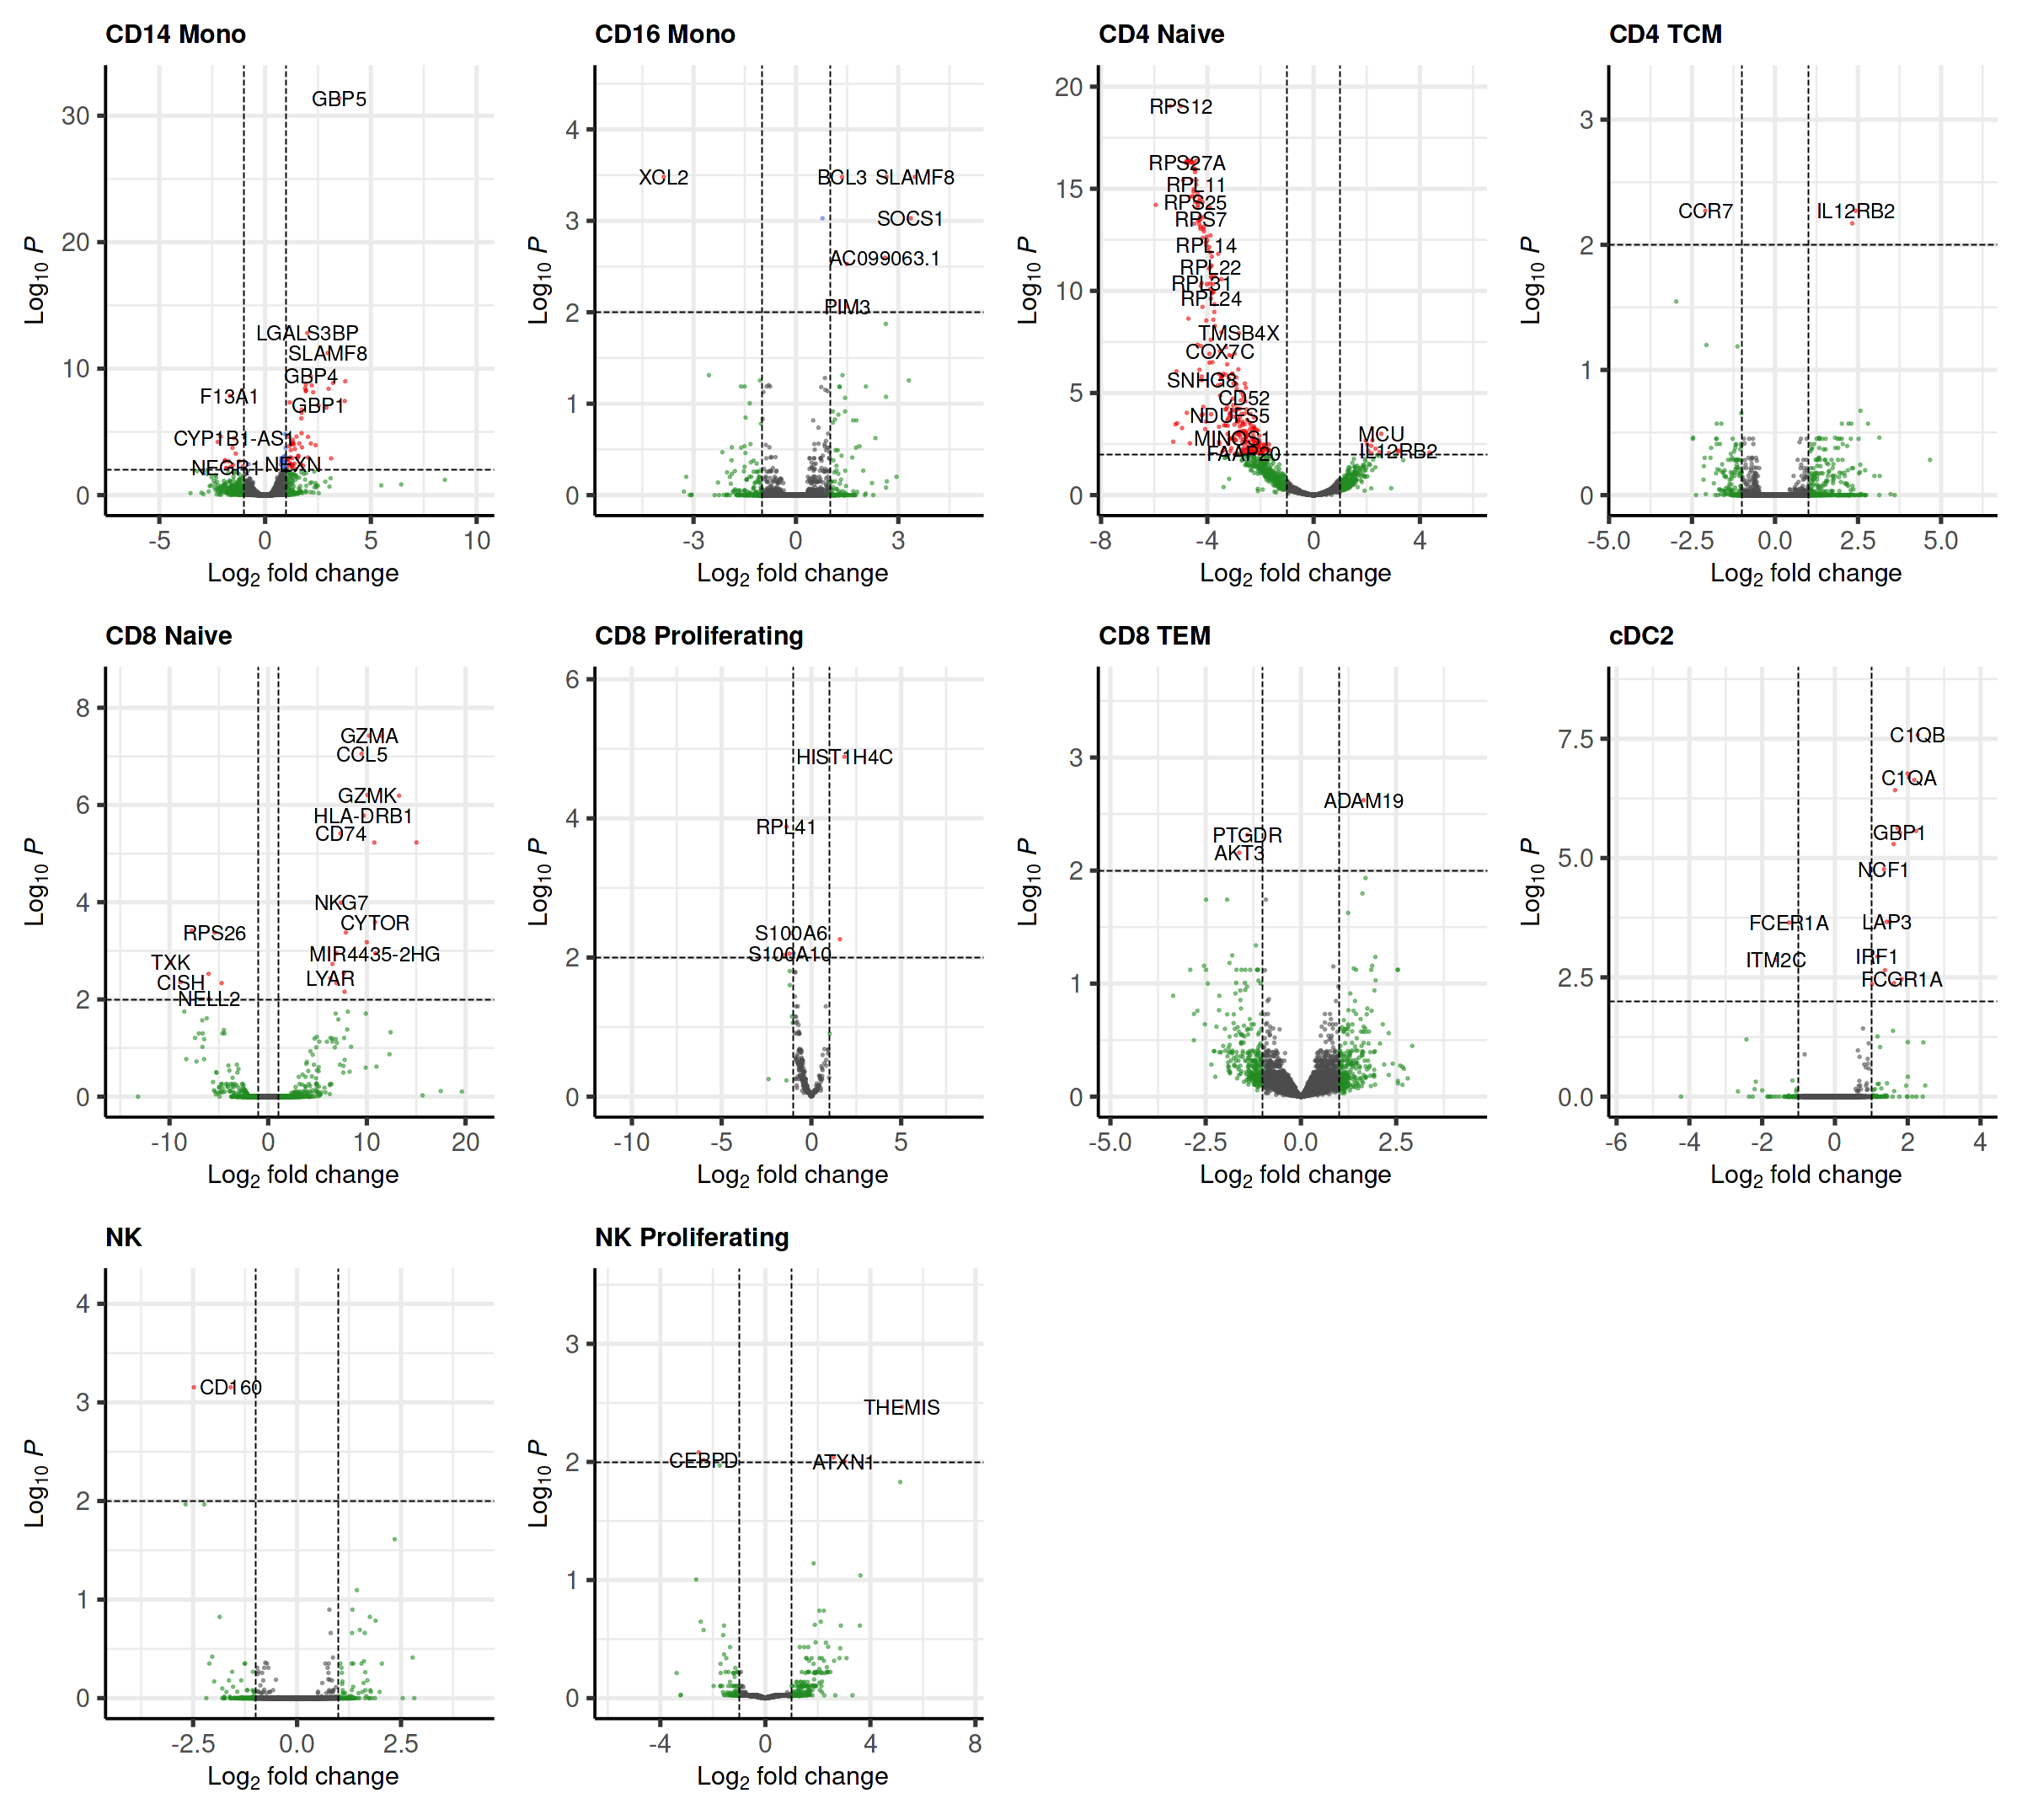

In [20]:
# Figure 3D
options(repr.plot.width=20, repr.plot.height=18)
wrap_plots(volcones_deseq2_separate_CR)

In [55]:
upregulated_separate=lapply(res_tables_CR, plotcnet, pcutoff=0.01, direction='up', wraplength=100) #Can't run in parallel because of org.Hs.eg.db

In [56]:
upregulated_separate_plot=map(upregulated_separate, 2)

In [66]:
wrapplot_separate_up=wrap_plots(upregulated_separate_plot[!sapply(upregulated_separate_plot, is.null)], ncol = 2) &  guides(fill=guide_legend(title="logFC")) & 
  theme(plot.margin = margin(5, 10, 10, 20))

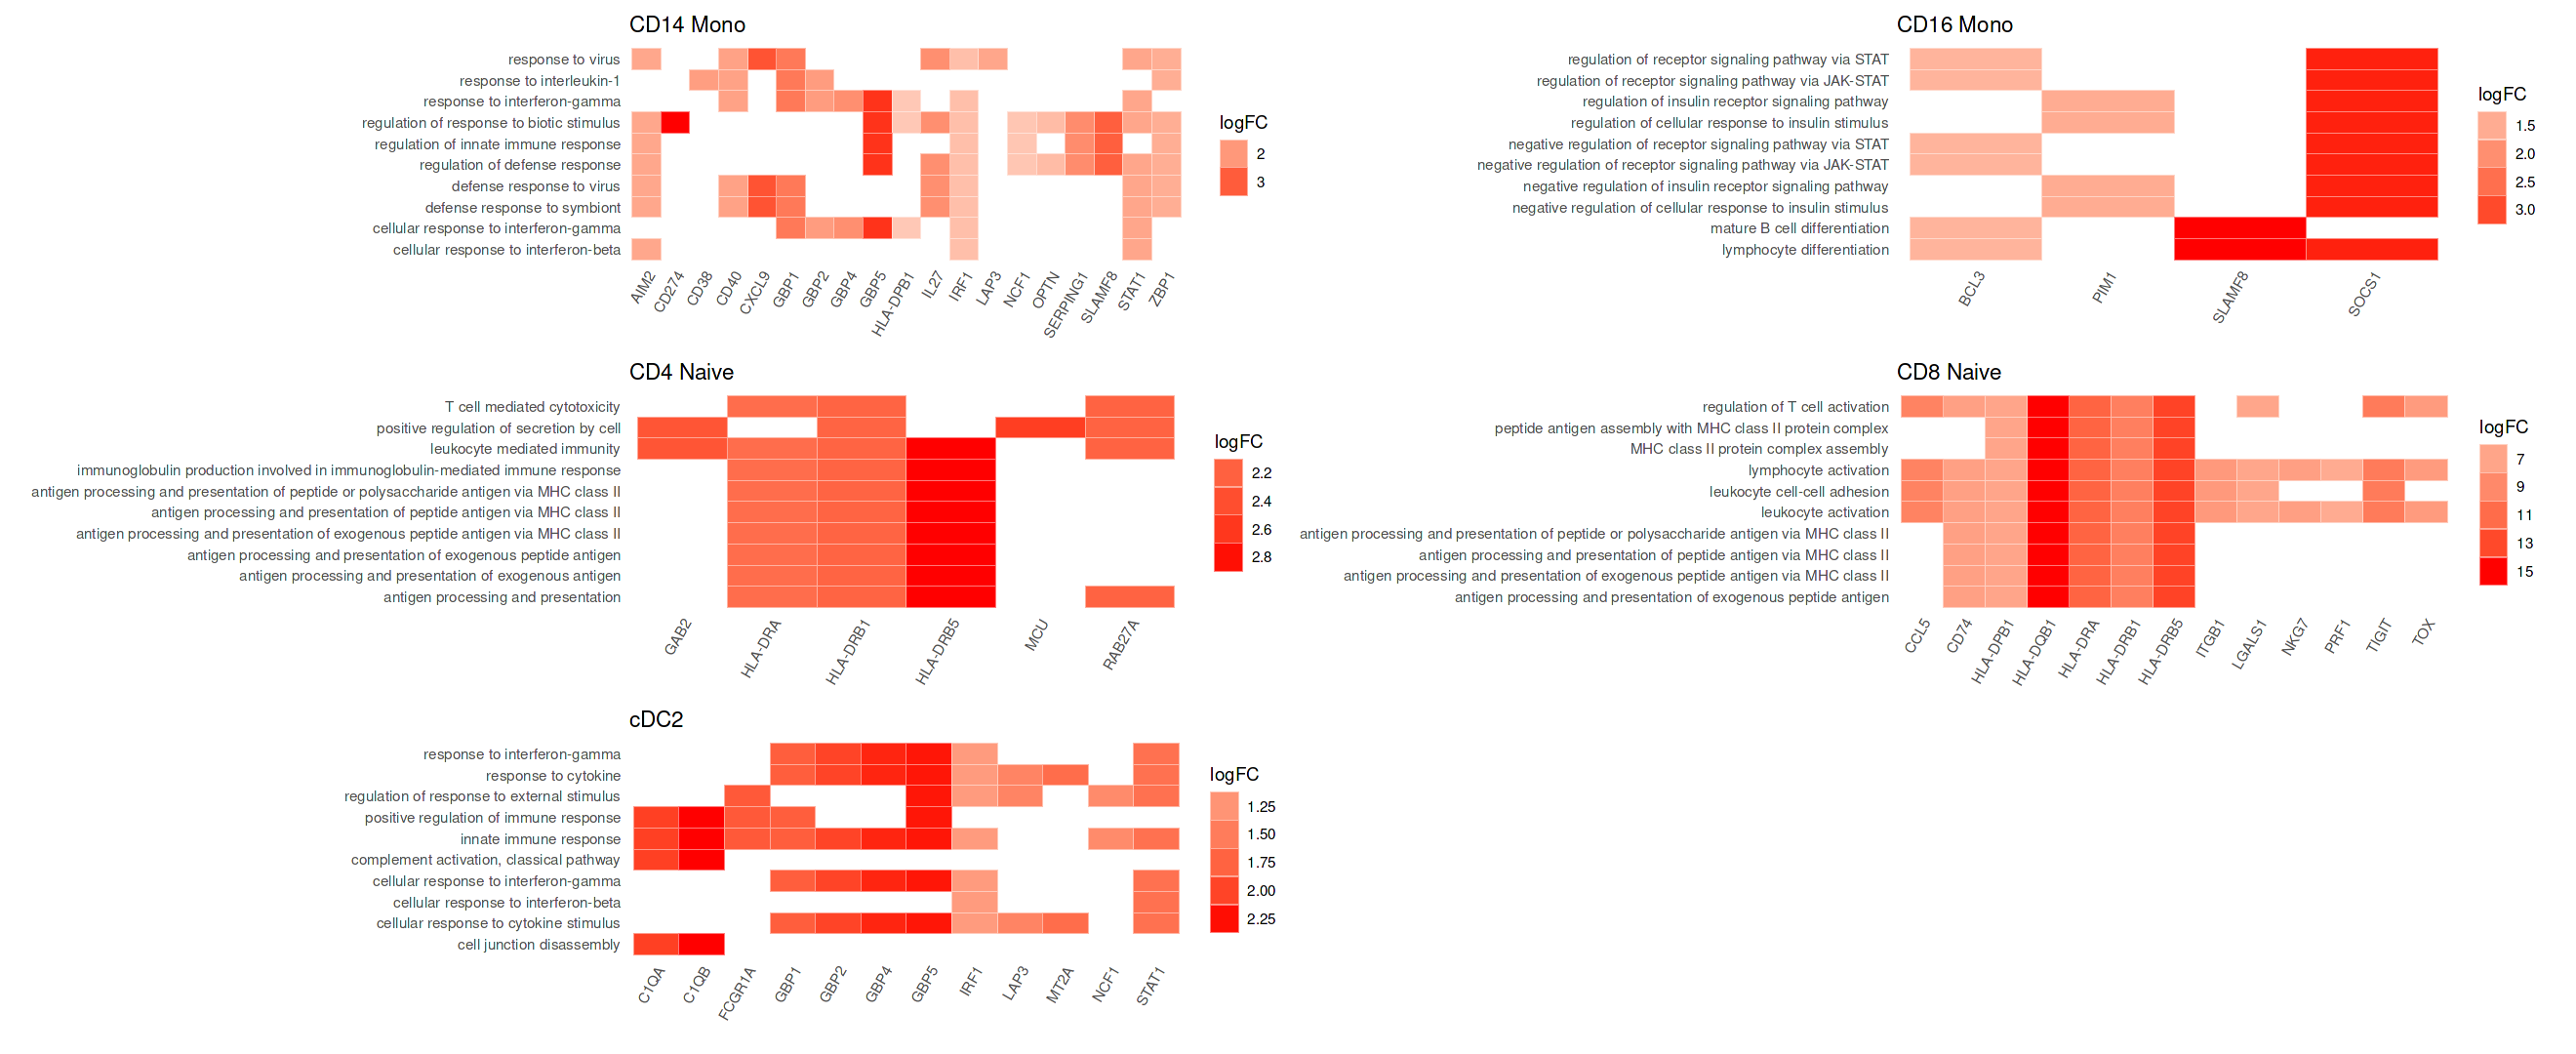

In [67]:
options(repr.plot.width=22, repr.plot.height=9)
wrapplot_separate_up

In [43]:
downregulated_separate=lapply(res_tables_CR, plotcnet, pcutoff=0.01, direction='down') #Can't run in parallel because of org.Hs.eg.db

In [44]:
downregulated_separate_plot=map(downregulated_separate, 2)

In [81]:
downregulated_separate_plot_filtered=downregulated_separate_plot[!sapply(downregulated_separate_plot, is.null)]

In [ ]:
wrapplot_separate_down=wrap_plots(downregulated_separate_plot[!sapply(downregulated_separate_plot, is.null)], ncol = 1) &  guides(fill=guide_legend(title="logFC")) & 
  theme(plot.margin = margin(10, 10, 10, 10))

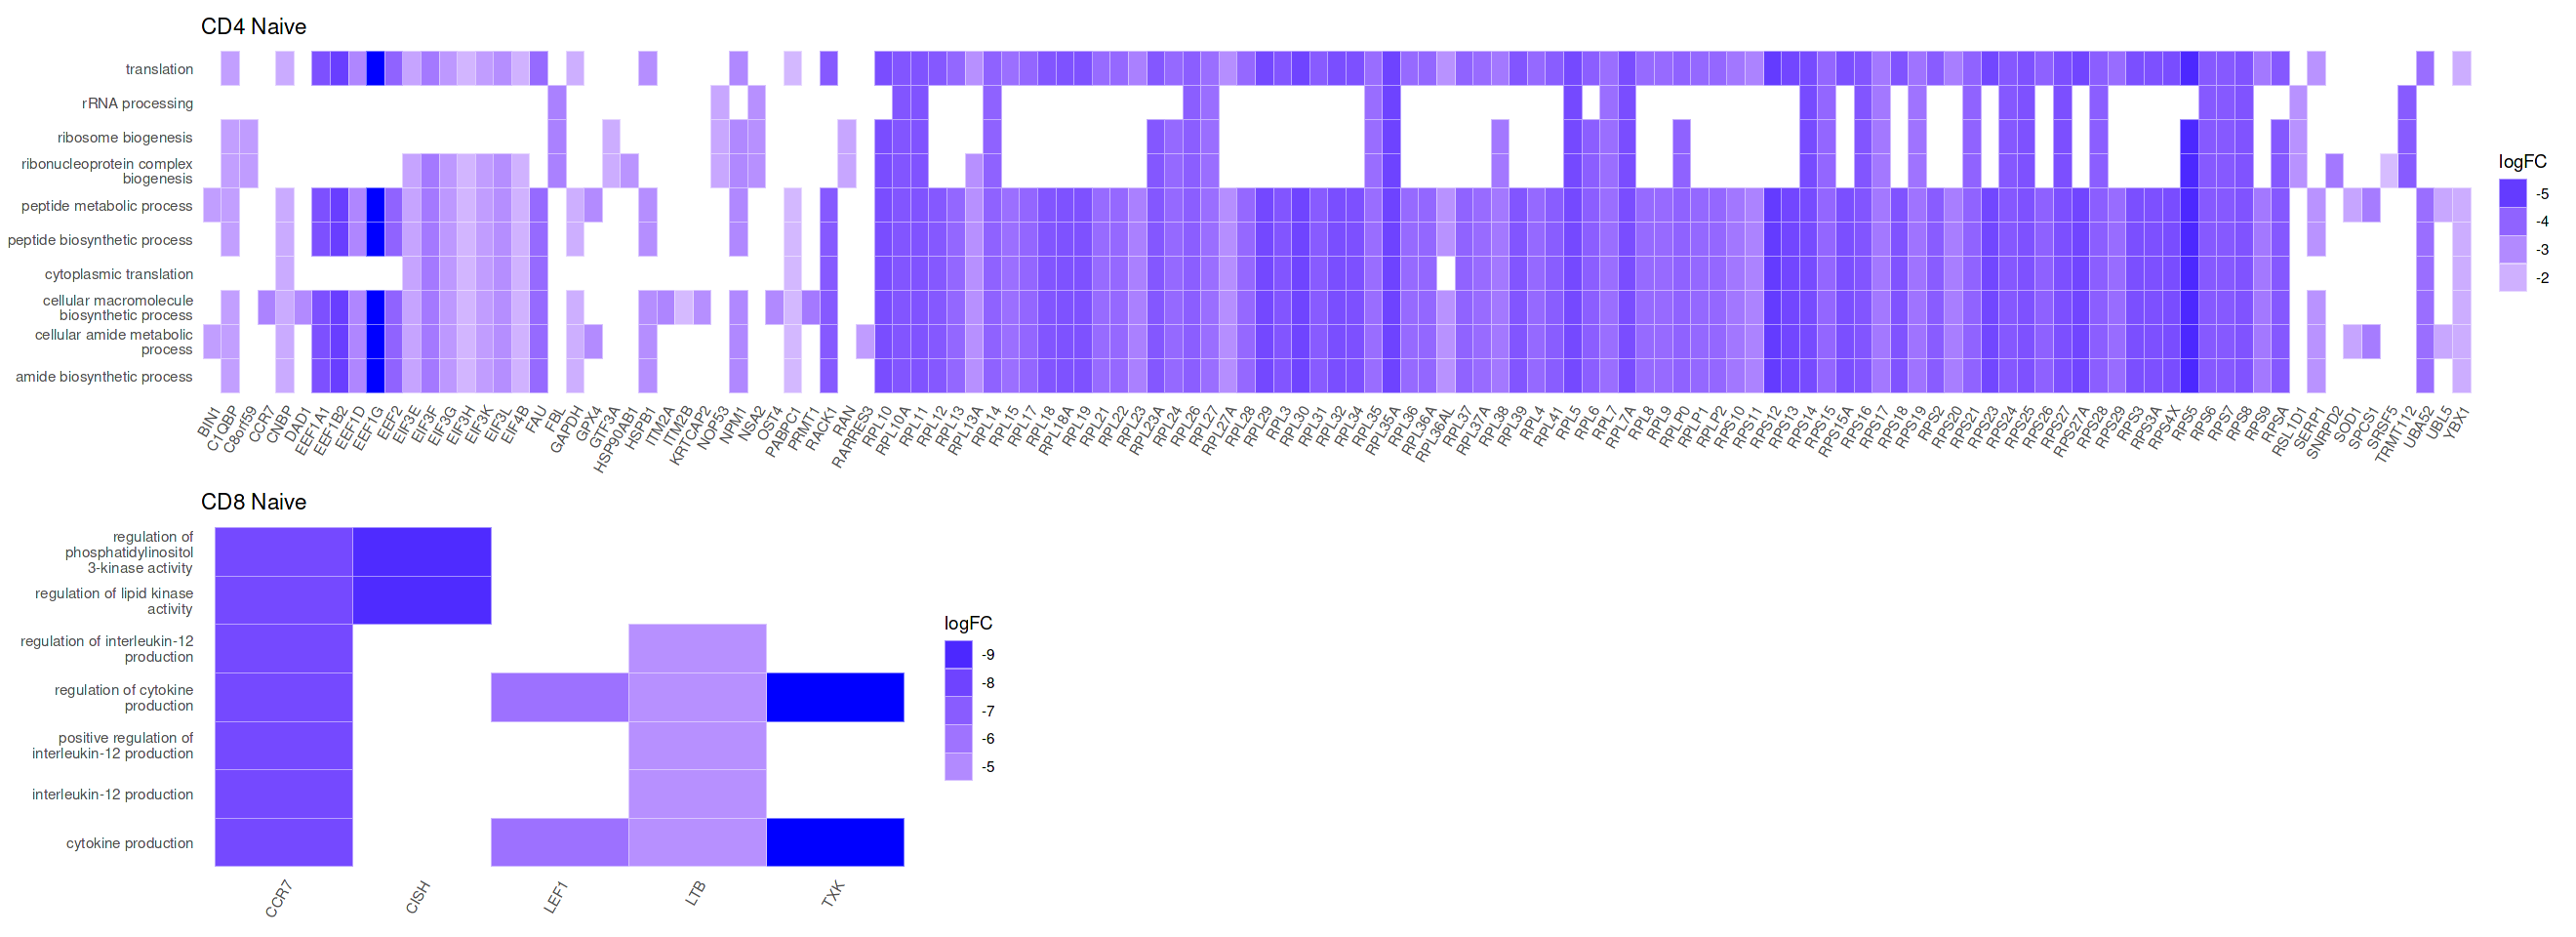

In [89]:
options(repr.plot.width=22, repr.plot.height=8)
downregulated_separate_plot_filtered[[1]]/(downregulated_separate_plot_filtered[[2]]+plot_spacer()+plot_spacer())& 
guides(fill=guide_legend(title="logFC"))